<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/callbacks/UpTrainCallback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UpTrain Callback Handler

UpTrain ([github](https://github.com/uptrain-ai/uptrain) || [website](https://github.com/uptrain-ai/uptrain/) || [docs](https://docs.uptrain.ai/)) is an open-source platform to evaluate and improve GenAI applications. It provides grades for 20+ preconfigured checks (covering language, code, embedding use cases), performs root cause analysis on failure cases and gives insights on how to resolve them. 

This notebook showcases how to use UpTrain Callback Handler to evaluate different components of your RAG pipelines.

## 1. **RAG Query Engine Evaluations**:
The RAG query engine plays a crucial role in retrieving context and generating responses. To ensure its performance and response quality, we conduct the following evaluations:

- **[Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance)**: Determines if the retrieved context has sufficient information to answer the user query or not.
- **[Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy)**: Assesses if the LLM's response can be verified via the retrieved context.
- **[Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness)**: Checks if the response contains all the information required to answer the user query comprehensively.

## 2. **Sub-Question Query Generation Evaluation**:
The SubQuestionQueryGeneration operator decomposes a question into sub-questions, generating responses for each using an RAG query engine. To measure it's accuracy, we use:

- **[Sub Query Completeness](https://docs.uptrain.ai/predefined-evaluations/query-quality/sub-query-completeness)**: Assures that the sub-questions accurately and comprehensively cover the original query.

## 3. **Re-Ranking Evaluations**:
Re-ranking involves reordering nodes based on relevance to the query and choosing the top nodes. Different evaluations are performed based on the number of nodes returned after re-ranking.

a. Same Number of Nodes
- **[Context Reranking](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-reranking)**: Checks if the order of re-ranked nodes is more relevant to the query than the original order.

b. Different Number of Nodes:
- **[Context Conciseness](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-conciseness)**: Examines whether the reduced number of nodes still provides all the required information.

These evaluations collectively ensure the robustness and effectiveness of the RAG query engine, SubQuestionQueryGeneration operator, and the re-ranking process in the LlamaIndex pipeline.

#### **Note:** 
- We have performed evaluations using basic RAG query engine, the same evaluations can be performed using the advanced RAG query engine as well.
- Same is true for Re-Ranking evaluations, we have performed evaluations using SentenceTransformerRerank, the same evaluations can be performed using other re-rankers as well.

## Install Dependencies and Import Libraries

Install notebook dependencies.

In [ ]:
%pip install llama-index-readers-web
%pip install llama-index-callbacks-uptrain
%pip install -q html2text llama-index pandas tqdm uptrain torch sentence-transformers

Import libraries.


In [ ]:
from llama_index.core import Settings, VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.web import SimpleWebPageReader
from llama_index.core.callbacks import CallbackManager
from llama_index.callbacks.uptrain.base import UpTrainCallbackHandler
from llama_index.core.query_engine import SubQuestionQueryEngine
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.llms.openai import OpenAI

import os

## Setup

You can choose between the following options for evaluating using UpTrain:
### 1. **UpTrain's Open-Source Software (OSS)**: 
You can use the open-source evaluation service to evaluate your model.
In this case, you will need to provie an OpenAI API key. You can get yours [here](https://platform.openai.com/account/api-keys).

Parameters:
- key_type="openai"
- api_key="OPENAI_API_KEY"
- project_name_prefix="PROJECT_NAME_PREFIX"


### 2. **UpTrain Managed Service and Dashboards**: 
You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

UpTrain Managed service provides:
1. Dashboards with advanced drill-down and filtering options
1. Insights and common topics among failing cases
1. Observability and real-time monitoring of production data
1. Regression testing via seamless integration with your CI/CD pipelines

The notebook contains some screenshots of the dashboards and the insights that you can get from the UpTrain managed service.

Parameters:
- key_type="uptrain"
- api_key="UPTRAIN_API_KEY"
- project_name_prefix="PROJECT_NAME_PREFIX"


**Note:** The `project_name_prefix` will be used as prefix for the project names in the UpTrain dashboard. These will be different for different types of evals. For example, if you set project_name_prefix="llama" and perform the sub_question evaluation, the project name will be "llama_sub_question_answering".

In [ ]:
os.environ[
    "OPENAI_API_KEY"
] = "sk-************"  # Replace with your OpenAI API key

callback_handler = UpTrainCallbackHandler(
    key_type="openai",
    api_key=os.environ["OPENAI_API_KEY"],
    project_name_prefix="llama",
)

Settings.callback_manager = CallbackManager([callback_handler])

## Load and Parse Documents

Load documents from Paul Graham's essay "What I Worked On".

In [ ]:
documents = SimpleWebPageReader().load_data(
    [
        "https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt"
    ]
)

Parse the document into nodes.

In [ ]:
parser = SentenceSplitter()
nodes = parser.get_nodes_from_documents(documents)

# 1. RAG Query Engine Evaluation

UpTrain callback handler will automatically capture the query, context and response once generated and will run the following three evaluations *(Graded from 0 to 1)* on the response:
- **[Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance)**: Determines if the retrieved context has sufficient information to answer the user query or not.
- **[Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy)**: Assesses if the LLM's response can be verified via the retrieved context.
- **[Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness)**: Checks if the response contains all the information required to answer the user query comprehensively.

In [ ]:
index = VectorStoreIndex.from_documents(
    documents,
)
query_engine = index.as_query_engine()

max_characters_per_line = 80
queries = [
    "What did Paul Graham do growing up?",
    "When and how did Paul Graham's mother die?",
    "What, in Paul Graham's opinion, is the most distinctive thing about YC?",
    "When and how did Paul Graham meet Jessica Livingston?",
    "What is Bel, and when and where was it written?",
]
for query in queries:
    response = query_engine.query(query)

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



Question: What did Paul Graham do growing up?
Response: Growing up, Paul Graham worked on writing short stories and programming. He started programming on an IBM 1401 in 9th grade using an early version of Fortran. Later, he got a TRS-80 computer and wrote simple games, a rocket prediction program, and a word processor. Despite his interest in programming, he initially planned to study philosophy in college before eventually switching to AI.

Context Relevance Score: 0.0
Factual Accuracy Score: 1.0
Response Completeness Score: 1.0



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



Question: When and how did Paul Graham's mother die?
Response: Paul Graham's mother died when he was 18 years old, from a brain tumor.

Context Relevance Score: 0.0
Factual Accuracy Score: 0.0
Response Completeness Score: 0.5



100%|██████████| 1/1 [00:01<00:00,  1.48s/it]



Question: What, in Paul Graham's opinion, is the most distinctive thing about YC?
Response: The most distinctive thing about Y Combinator, according to Paul Graham, is that instead of deciding for himself what to work on, the problems come to him. Every 6 months, a new batch of startups brings their problems, which then become the focus of YC. This engagement with a variety of startup problems and the direct involvement in solving them is what Graham finds most unique about Y Combinator.

Context Relevance Score: 1.0
Factual Accuracy Score: 0.3333333333333333
Response Completeness Score: 1.0



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Question: When and how did Paul Graham meet Jessica Livingston?
Response: Paul Graham met Jessica Livingston at a big party at his house in October 2003.

Context Relevance Score: 1.0
Factual Accuracy Score: 0.5
Response Completeness Score: 1.0



100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Question: What is Bel, and when and where was it written?
Response: Bel is a new Lisp that was written in Arc. It was developed over a period of 4 years, from March 26, 2015 to October 12, 2019. The majority of Bel was written in England.

Context Relevance Score: 1.0
Factual Accuracy Score: 1.0
Response Completeness Score: 1.0



Here's an example of the dashboard showing how you can filter and drill down to the failing cases and get insights on the failing cases:
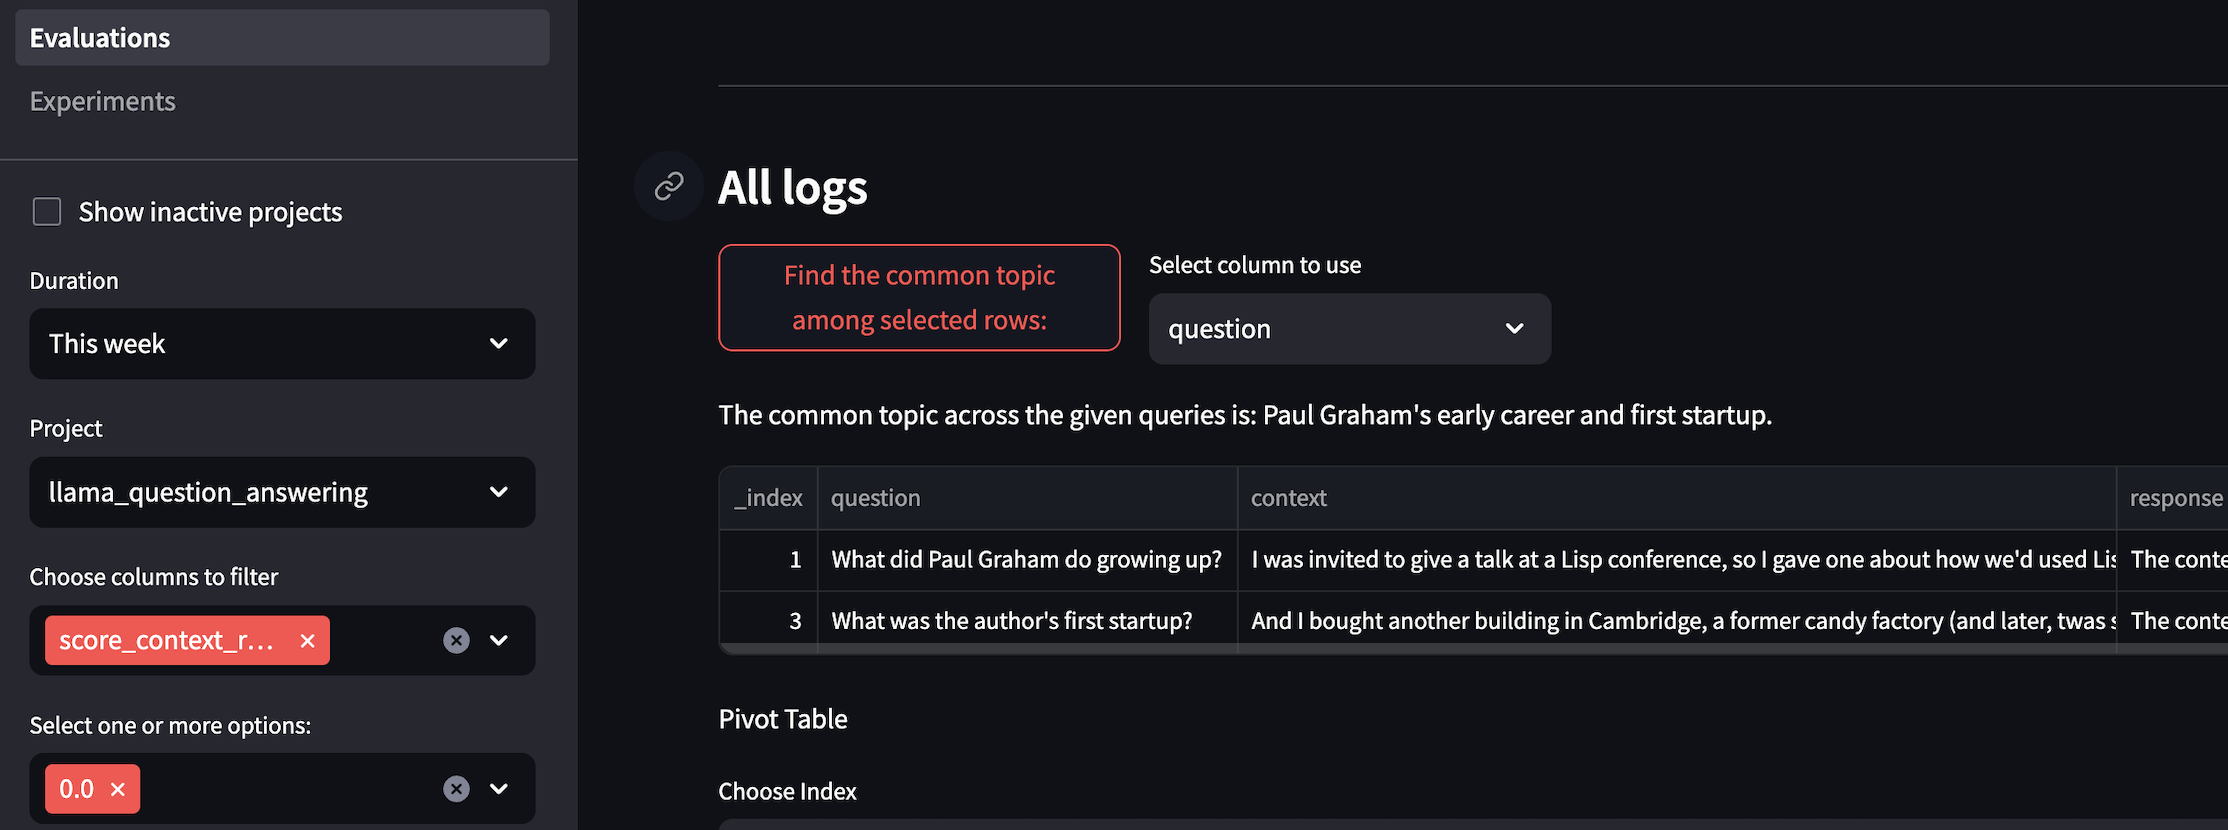

# 2. Sub-Question Query Engine Evaluation

The **sub-question query engine** is used to tackle the problem of answering a complex query using multiple data sources. It first breaks down the complex query into sub-questions for each relevant data source, then gathers all the intermediate responses and synthesizes a final response.

UpTrain callback handler will automatically capture the sub-question and the responses for each of them once generated and will run the following three evaluations *(Graded from 0 to 1)* on the response:
- **[Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance)**: Determines if the retrieved context has sufficient information to answer the user query or not.
- **[Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy)**: Assesses if the LLM's response can be verified via the retrieved context.
- **[Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness)**: Checks if the response contains all the information required to answer the user query comprehensively.

In addition to the above evaluations, the callback handler will also run the following evaluation:
- **[Sub Query Completeness](https://docs.uptrain.ai/predefined-evaluations/query-quality/sub-query-completeness)**: Assures that the sub-questions accurately and comprehensively cover the original query.

In [ ]:
# build index and query engine
vector_query_engine = VectorStoreIndex.from_documents(
    documents=documents,
    use_async=True,
).as_query_engine()

query_engine_tools = [
    QueryEngineTool(
        query_engine=vector_query_engine,
        metadata=ToolMetadata(
            name="documents",
            description="Paul Graham essay on What I Worked On",
        ),
    ),
]

query_engine = SubQuestionQueryEngine.from_defaults(
    query_engine_tools=query_engine_tools,
    use_async=True,
)

response = query_engine.query(
    "How was Paul Grahams life different before, during, and after YC?"
)

Generated 3 sub questions.
[documents] Q: What did Paul Graham work on before YC?
[documents] Q: What did Paul Graham work on during YC?
[documents] Q: What did Paul Graham work on after YC?
[documents] A: After Y Combinator, Paul Graham decided to focus on painting as his next endeavor.
[documents] A: Paul Graham worked on writing essays and working on Y Combinator during YC.
[documents] A: Before Y Combinator, Paul Graham worked on projects with his colleagues Robert and Trevor.


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]



Question: What did Paul Graham work on after YC?
Response: After Y Combinator, Paul Graham decided to focus on painting as his next endeavor.

Context Relevance Score: 0.0
Factual Accuracy Score: 0.0
Response Completeness Score: 0.5


Question: What did Paul Graham work on during YC?
Response: Paul Graham worked on writing essays and working on Y Combinator during YC.

Context Relevance Score: 0.0
Factual Accuracy Score: 1.0
Response Completeness Score: 0.5


Question: What did Paul Graham work on before YC?
Response: Before Y Combinator, Paul Graham worked on projects with his colleagues Robert and Trevor.

Context Relevance Score: 0.0
Factual Accuracy Score: 0.0
Response Completeness Score: 0.5



100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Question: How was Paul Grahams life different before, during, and after YC?
Sub Query Completeness Score: 1.0



Here's an example of the dashboard visualizing the scores of the sub-questions in the form of a bar chart:

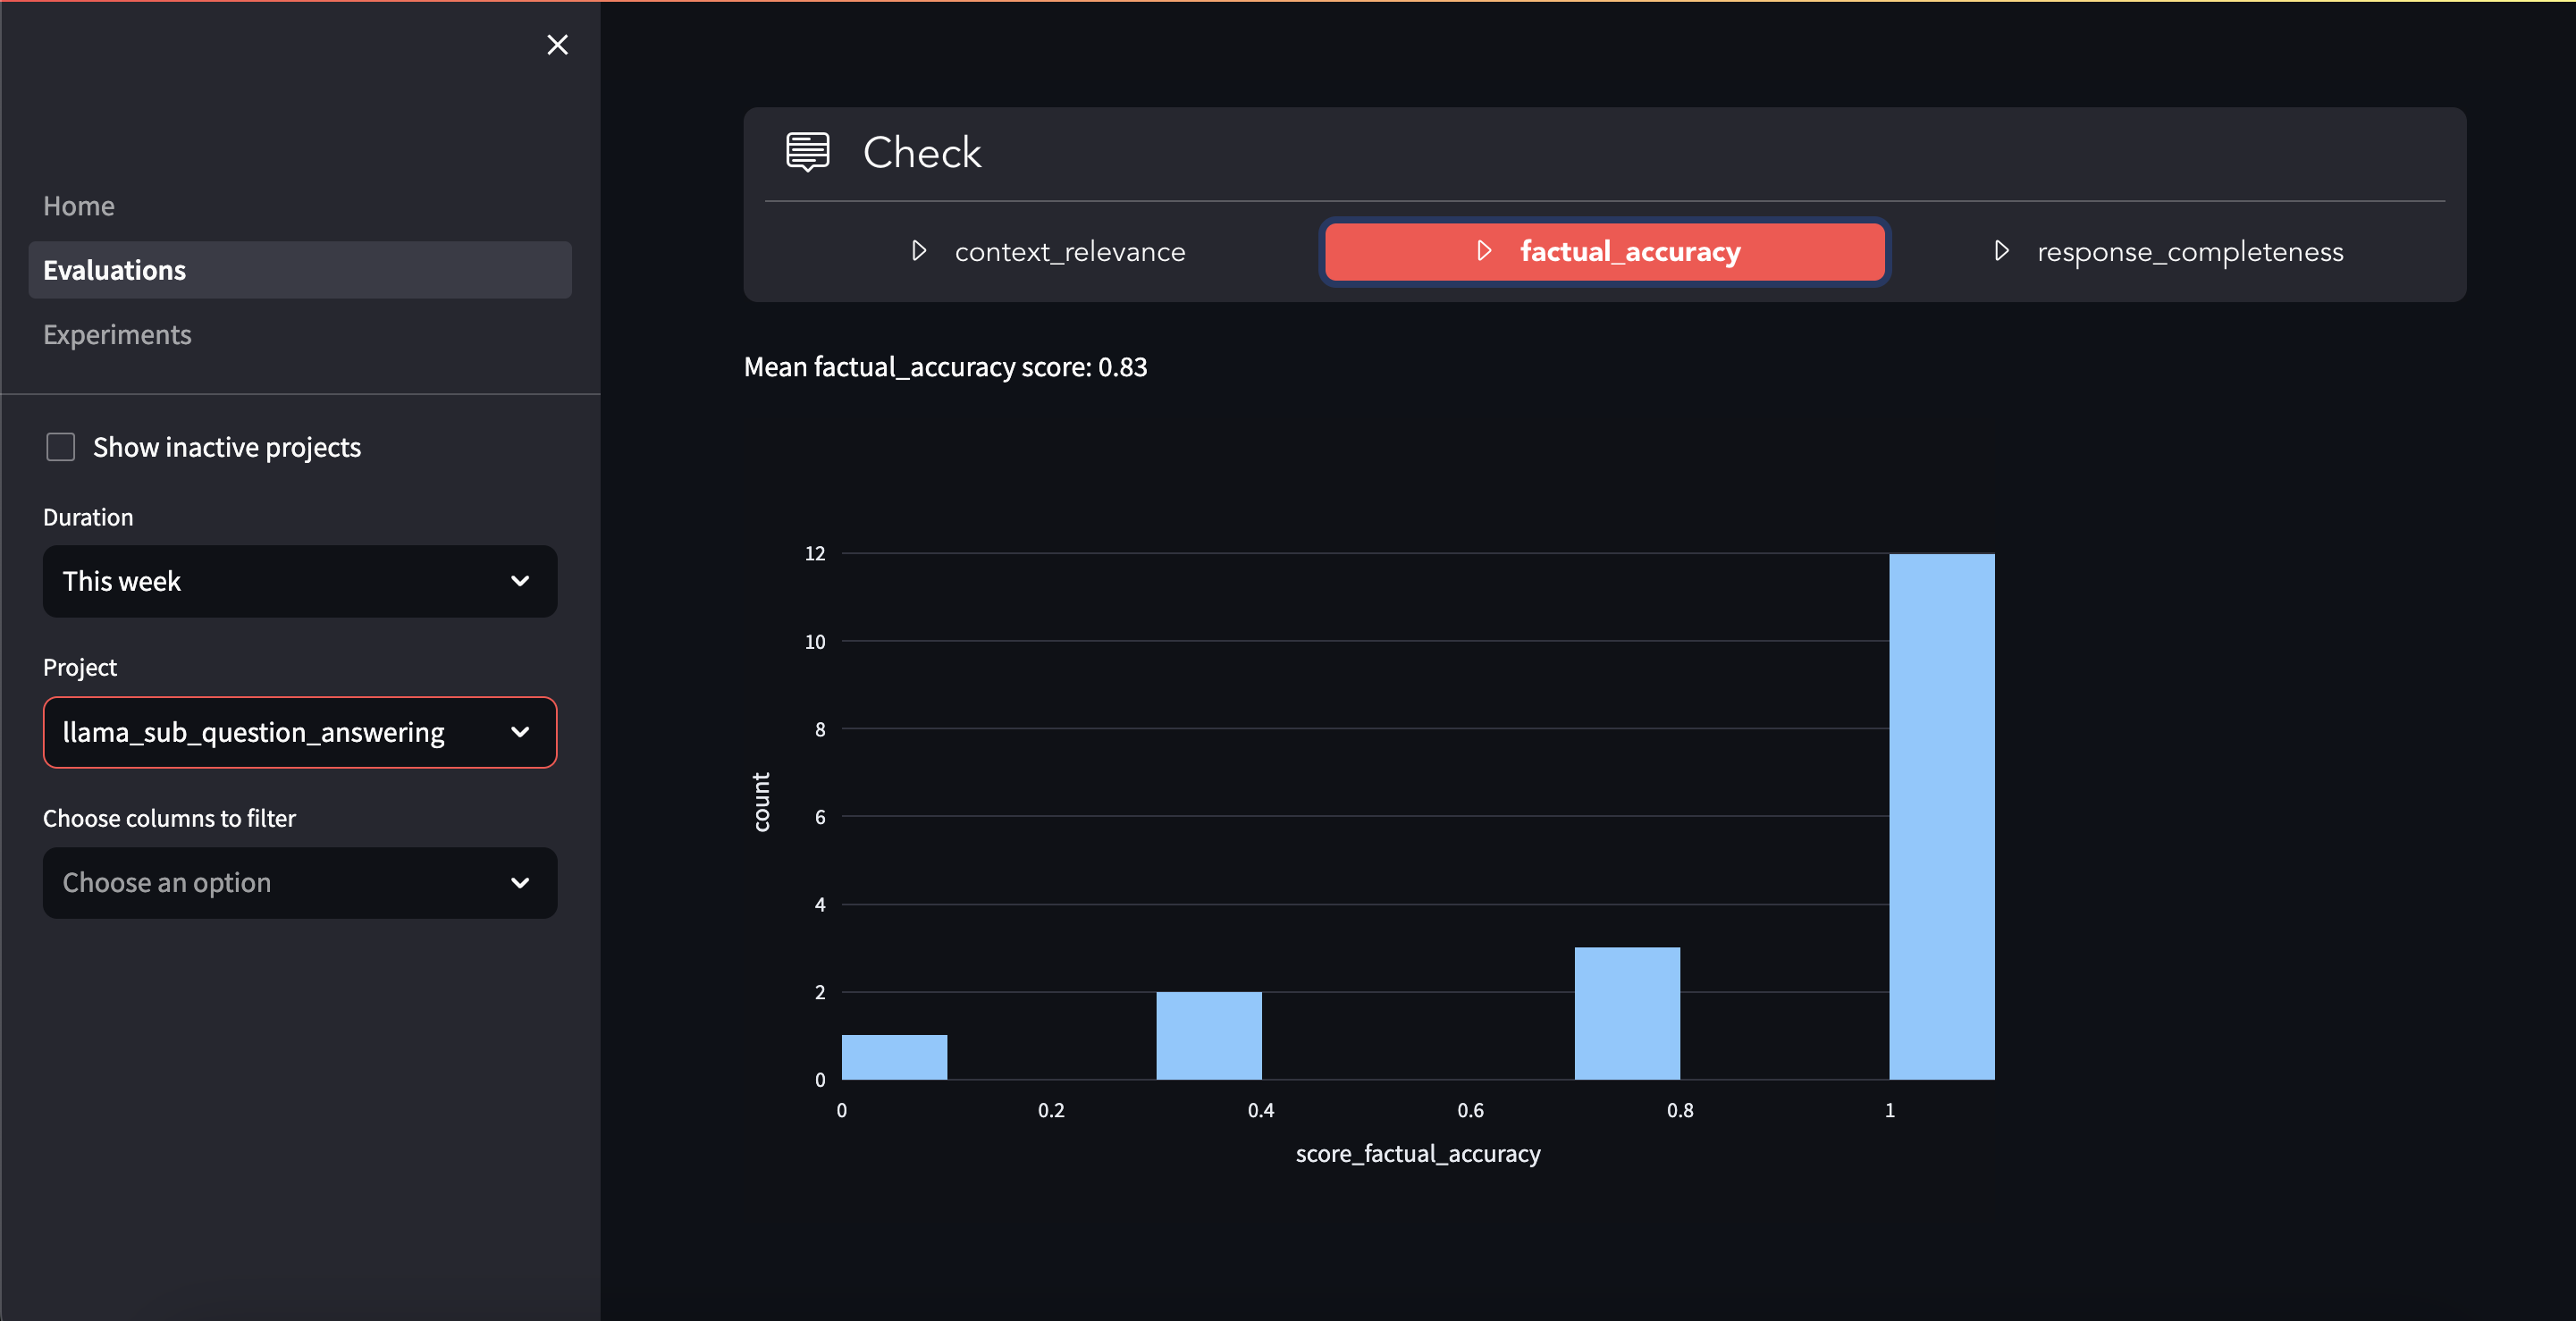

# 3. Re-ranking 

Re-ranking is the process of reordering the nodes based on their relevance to the query. There are multiple classes of re-ranking algorithms offered by Llamaindex. We have used LLMRerank for this example.

The re-ranker allows you to enter the number of top n nodes that will be returned after re-ranking. If this value remains the same as the original number of nodes, the re-ranker will only re-rank the nodes and not change the number of nodes. Otherwise, it will re-rank the nodes and return the top n nodes.

We will perform different evaluations based on the number of nodes returned after re-ranking.

## 3a. Re-ranking (With same number of nodes)

If the number of nodes returned after re-ranking is the same as the original number of nodes, the following evaluation will be performed:

- **[Context Reranking](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-reranking)**: Checks if the order of re-ranked nodes is more relevant to the query than the original order.

In [ ]:
callback_handler = UpTrainCallbackHandler(
    key_type="openai",
    api_key=os.environ["OPENAI_API_KEY"],
    project_name_prefix="llama",
)
Settings.callback_manager = CallbackManager([callback_handler])

rerank_postprocessor = SentenceTransformerRerank(
    top_n=3,  # number of nodes after reranking
    keep_retrieval_score=True,
)

index = VectorStoreIndex.from_documents(
    documents=documents,
)

query_engine = index.as_query_engine(
    similarity_top_k=3,  # number of nodes before reranking
    node_postprocessors=[rerank_postprocessor],
)

response = query_engine.query(
    "What did Sam Altman do in this essay?",
)

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]



Question: What did Sam Altman do in this essay?
Context Reranking Score: 1.0



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Question: What did Sam Altman do in this essay?
Response: Sam Altman was asked to become the president of Y Combinator after the original founders decided to step down and reorganize the company for long-term sustainability.

Context Relevance Score: 1.0
Factual Accuracy Score: 1.0
Response Completeness Score: 0.5



# 3b. Re-ranking (With different number of nodes)

If the number of nodes returned after re-ranking is the lesser as the original number of nodes, the following evaluation will be performed:

- **[Context Conciseness](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-conciseness)**: Examines whether the reduced number of nodes still provides all the required information.

In [ ]:
callback_handler = UpTrainCallbackHandler(
    key_type="openai",
    api_key=os.environ["OPENAI_API_KEY"],
    project_name_prefix="llama",
)
Settings.callback_manager = CallbackManager([callback_handler])

rerank_postprocessor = SentenceTransformerRerank(
    top_n=2,  # Number of nodes after re-ranking
    keep_retrieval_score=True,
)

index = VectorStoreIndex.from_documents(
    documents=documents,
)
query_engine = index.as_query_engine(
    similarity_top_k=5,  # Number of nodes before re-ranking
    node_postprocessors=[rerank_postprocessor],
)

# Use your advanced RAG
response = query_engine.query(
    "What did Sam Altman do in this essay?",
)

100%|██████████| 1/1 [00:02<00:00,  2.22s/it]



Question: What did Sam Altman do in this essay?
Context Conciseness Score: 0.0



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Question: What did Sam Altman do in this essay?
Response: Sam Altman offered unsolicited advice to the author during a visit to California for interviews.

Context Relevance Score: 0.0
Factual Accuracy Score: 1.0
Response Completeness Score: 0.5



# UpTrain's Managed Service Dashboard and Insights

To use the UpTrain's managed service via the UpTrain callback handler, the only change required is to set the `key_type` and `api_key` parameters. The rest of the code remains the same.

```python
callback_handler = UpTrainCallbackHandler(
    key_type="uptrain",
    api_key="up-******************************",
    project_name_prefix="llama",
)
```

Here's a short GIF showcasing the dashboard and the insights that you can get from the UpTrain managed service:

![output.gif](https://uptrain-assets.s3.ap-south-1.amazonaws.com/images/llamaindex/output.gif)